## transform

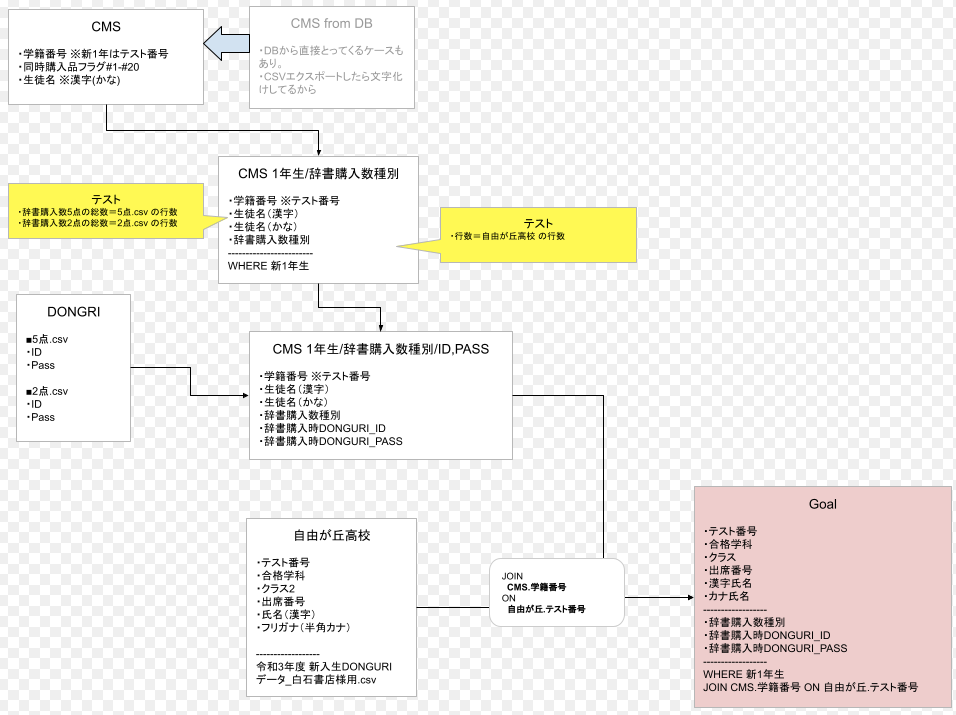

https://docs.google.com/drawings/d/1nPZNZhNc1T-E6eS-CYzrw2lRDZeQTf0oqf-ssvxaAmg/edit?usp=sharing


## CAUTION


- `cms.学籍番号` と `自由が丘.テスト番号`でJOINできなくなったので、生徒名でJOINすることとする

<br><br>

---

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

In [ ]:
CURRENT_DIR = "/content/drive/MyDrive/Shared/白石Re:Invent/system/自由が丘_学籍番号-テスト番号-紐付け自動化"

## View rawdata

- pandas.read_csv 列がずれる [reference](https://zetaseya.work/python%E3%80%81pandas%E3%81%AEcsv%E3%83%87%E3%83%BC%E3%82%BF%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%81%BF%E3%81%A7%E3%83%98%E3%83%83%E3%83%80%E3%83%BC%E3%81%AE%E5%88%97%E3%81%8C%E3%81%9A%E3%82%8C%E3%81%A6/)

In [ ]:
# 白石書店CMS
s_cms_fpath = CURRENT_DIR + "/" + "sample_data/exported-from-s-cms/" + "2021-08-0221_02_58payment_fixcol.csv"
df_scms = pd.read_csv(s_cms_fpath, encoding="shift-jis")
df_scms.head(3)

In [ ]:
# DONGURI
DONGURI_DIR = CURRENT_DIR + "/sample_data/アカウント情報_白石書店用サンプル/"
DICT2_PATH = DONGURI_DIR + "2021年新1年生_ジーニアス英和・和英＋英英辞典_アカウント.xlsx"
DICT5_PATH = DONGURI_DIR + "2021年新1年生_ジーニアス５辞書＋英英辞典セット_アカウント.xlsx"

df_2dict_acnts = pd.read_excel(DICT2_PATH)
df_5dict_acnts = pd.read_excel(DICT5_PATH)

display(df_2dict_acnts.head(3))
display(df_5dict_acnts.head(3))

In [ ]:
# juyugaoka students
student_path = CURRENT_DIR + "/sample_data/" + "令和3年度　新入生DONGURIデータ_白石書店様用_utf8.csv"
# こちらでutf-8に変換した
df_students = pd.read_csv(student_path, encoding="utf-8")

df_students.head(3)

# Check Data

## 同時購入NOとやらには有効な値が入っているのか？

### conclusion

- 合計値は、0, 1, 2, 3 の3パターンであった。
- 合計値が0, 2, 5 になるのかと思っていたが、そうではないらしい。
- ★要調査

In [ ]:
_target_cols = [x for x in df_scms.columns if ('同時購入品' in x) and ('NO' in x)]
_df_scms = df_scms[_target_cols].copy()
_doji_konyu_sum = _df_scms.sum(axis=1) # axis: 1=columns
print(_doji_konyu_sum.describe())
_doji_konyu_sum.plot()

## 同時購入NOとやらには何番に何の値が入っているんだ？

### Conclusion

- No1 , No2 にだけ値が入っているようだ
- したがって、いずれかが2辞書、5辞書なのだろう
- どのフラグが立っているかで判断するということ
- **No1 = 5辞書 / No2 = 2辞書** らしい

In [ ]:
_doji_konyu_row_sum = _df_scms.sum(axis=0) # axis: 0=rows
_doji_konyu_row_sum.plot.bar()

## 生徒名が一致するデータはあるのか？

### Conclusion

- 488名（自由が丘提供データ）中、406名はCMSから取ってきたデータと整合した
- 一致していないものの多くは、文字化けと思われる
- 【★要検討】それ以外の要素がないかどうか確認する必要がある
- 【★要検討】文字化けしたデータに対するオペレーションを検討する。必須条件として、少なくとも「プログラムで実現できないものを出力して、あとは手動で対応する」という手段がとれるような出力にすべきだろう。

In [ ]:
# students from juyugaoka-data
_sr_students_from_j = df_students['氏\u3000名'].copy()
_sr_students_from_j = _sr_students_from_j.str.strip() # remove white space
_sr_students_from_j = _sr_students_from_j.str.replace("　", "") # remove ZENKAKU space

# students from cms data
_temp = df_scms['生徒名'].copy()
_temp = _temp.str.split('(', expand=True)[0] # exclude (kana)
_sr_students_from_cms = _temp.str.strip() # remove white space
_sr_students_from_cms = _temp.str.replace("　", "") # remove ZENKAKU space

# ---------
display(_sr_students_from_j)
display(_sr_students_from_cms)

In [ ]:
_isin_sr = _sr_students_from_j.isin(values=_sr_students_from_cms.values)
_sum_isin = _isin_sr.sum()
print(f'sum isin = {_sum_isin}')
display(_isin_sr)

## CMS.教科書タイトル から学年を判断できるか？新一年生だけを取り出したい

### Conclusion

行けそう

In [ ]:
_text_titles_uniq = df_scms['教科書タイトル'].unique()
_text_titles_uniq

In [ ]:
_newbee_text_titles = [x for x in _text_titles_uniq if '1年' in x]
_newbee_text_titles

## 生徒のパターンは、辞書なし・辞書2・辞書5の3パターン？

- 段取り
  - 1年生を取り出す
  - 同時購入No1（5辞書）, No2（2辞書）をチェック

### Conclusion

80人ぐらいは普通に辞書なしの人いそう


In [ ]:
_newbee_flg = df_scms['教科書タイトル'].str.contains('1年')
_newbee = df_scms[_newbee_flg]
# テストユーザーも混ざっている
_newbee = _newbee[['生徒名', '教科書タイトル', '同時購入品1NO', '同時購入品2NO']]


# 同時購入なしの生徒をとりあえず出力してみる。本物のユーザーっぽいものがあるか確認する
_temp = _newbee[['同時購入品1NO', '同時購入品2NO']].copy()
_temp_sum_col = _temp.sum(axis=1)
_newbee_no_konyu = _newbee[_temp_sum_col == 0]

for index, (i, v) in enumerate(_newbee_no_konyu.iterrows()):
  name = v['生徒名']
  print(f'{index}: {name}')

In [ ]:
_count_dic2_acc = df_2dict_acnts['ユーザー名'].count()
_count_dic5_acc = df_5dict_acnts['ユーザー名'].count()
_count_student_all = df_students['テスト番号'].count()

print(f"dic2 acc : {_count_dic2_acc}")
print(f"dic5 acc : {_count_dic5_acc}")
print(f"all students : {_count_student_all}")

_no_dict_students = _count_student_all - (_count_dic2_acc + _count_dic5_acc)
print(f"no dict students : {_no_dict_students} (expected)")

## CMS / 1年生 / 辞書購入数種別

In [ ]:
target_cols = [x for x in df_scms.columns if ('同時購入品' in x) and ('NO' in x)]
target_cols.extend(['id', '学籍番号', '生徒名', '教科書タイトル'])

df_scms_ = df_scms[target_cols]
df_scms_.head(5)

# ＝＝＝＝＝＝＝＝

---

<br><br><br>


# MAIN

## Setup for App

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

In [ ]:
from dataclasses import dataclass
from enum import IntEnum
from typing import List, Tuple

## Configurations

In [ ]:
@dataclass
class Config:
  root: str # root dir
  cms_dir: str # CMS dir
  cms_csv_fn: str # CMS exported csv file name
  dong_dir: str # DONGURI data dir
  dong_dic2_acc_fn: str # DONGRI account list file name 2dic
  dong_dic5_acc_fn: str # DONGRI account list file name 5dic
  jiyuga_dir: str # jiyugaoka school sample dir
  jiyuga_newbee_fn: str # jiyugaoka newbee list file name

  @staticmethod
  def join_path(pathlist: List[str]) -> str:
    _joined = '/'.join(pathlist)
    return _joined

  def get_cms_path(self) -> str:
    _pathlist = [self.root, self.cms_dir, self.cms_csv_fn]
    _fullpath = Config.join_path(_pathlist)
    return _fullpath
  
  def get_dng2dic_path(self) -> str:
    _pathlist = [self.root, self.dong_dir, self.dong_dic2_acc_fn]
    _fullpath = Config.join_path(_pathlist)
    return _fullpath

  def get_dng5dic_path(self) -> str:
    _pathlist = [self.root, self.dong_dir, self.dong_dic5_acc_fn]
    _fullpath = Config.join_path(_pathlist)
    return _fullpath

  def get_jiyu_newbee_path(self) -> str:
    _pathlist = [self.root, self.jiyuga_dir, self.jiyuga_newbee_fn]
    _fullpath = Config.join_path(_pathlist)
    return _fullpath

cfg = Config(
    root="/content/drive/MyDrive/Shared/白石Re:Invent/system/自由が丘_学籍番号-テスト番号-紐付け自動化",
    cms_dir="sample_data/exported-from-s-cms",
    cms_csv_fn="2021-08-0221_02_58payment_fixcol.csv",
    dong_dir="sample_data/アカウント情報_白石書店用サンプル",
    dong_dic2_acc_fn="2021年新1年生_ジーニアス英和・和英＋英英辞典_アカウント.xlsx",
    dong_dic5_acc_fn="2021年新1年生_ジーニアス５辞書＋英英辞典セット_アカウント.xlsx",
    jiyuga_dir="sample_data",
    jiyuga_newbee_fn="令和3年度　新入生DONGURIデータ_白石書店様用_utf8.csv"
)

In [ ]:
@dataclass
class BuyingDicType:
  DIC_5: str='5辞書'
  DIC_2: str='2辞書'
  DIC_NONE: str='購入しない'
  NULL: str='（手動で作成）'

buying_dic_type = BuyingDicType()

## Class Definition

In [ ]:
cfg.get_cms_path()

In [ ]:
class CmsData:
  def __init__(self, csv_path: str):
    self.load_prep(csv_path)

  def load_prep(self, csv_path: str) -> None:
    self.data = pd.read_csv(csv_path, encoding="shift-jis")
    # prep : XXX(kana) --> XXX
    _temp = self.data['生徒名'].copy()
    _temp = _temp.str.split('(', expand=True)[0] # exclude (kana)
    _temp = _temp.str.strip() # remove white space
    _temp = _temp.str.replace("　", "") # remove ZENKAKU space
    self.data['生徒名'] = _temp.copy()

  def get_student_id(self) -> pd.Series:
    return self.data[self.join_target_col()].copy()

  def join_target_col(self) -> str:
    return '学籍番号'

  def get_names(self) -> pd.Series:
    return self.data['生徒名'].copy()

  def calc_dict_buy_type(self) -> None:
    _dict_buy_5_flg = (self.data['同時購入品1NO'] > 0)
    _dict_buy_2_flg = (self.data['同時購入品2NO'] > 0)
    _dict_buy_n_flg = ~(_dict_buy_5_flg | _dict_buy_2_flg)
    
    _dict_buy_type: List[str] = []
    buying_dic_type = BuyingDicType()
    for d5, d2, dno in zip(_dict_buy_5_flg, _dict_buy_2_flg, _dict_buy_n_flg):
      _cur_type = buying_dic_type.DIC_NONE
      if d5 == True:
        _cur_type = buying_dic_type.DIC_5
      elif d2 == True:
        _cur_type = buying_dic_type.DIC_2
      _dict_buy_type.append(_cur_type)
    
    self.data['副教材タイプ'] = _dict_buy_type

In [ ]:
class DonguriAccount:
  def __init__(self, exl_path: str):
    self.load_prep(exl_path)

  def load_prep(self, exl_path: str) -> None:
    self.data = pd.read_excel(exl_path)

  def get_head(self, num: int) -> pd.DataFrame:
    self.used_acc_num = min(num, self.data.shape[0])
    return self.data.head(num).copy()

  def get_rest_acc_num(self) -> int:
    return (self.data.shape[0] - self.used_acc_num)

  def get_rest_of(self) -> pd.DataFrame:
    return self.data.tail(self.get_rest_acc_num())

In [ ]:
class JiyuStudents:
  def __init__(self, csv_path: str):
    self.load_prep(csv_path)

  def load_prep(self, csv_path: str) -> None:
    self.data = pd.read_csv(csv_path, encoding='utf-8')
    _temp = self.data[self.get_name_col_name()].copy()
    _temp = _temp.str.strip() # remove white space
    _temp = _temp.str.replace("　", "") # remove ZENKAKU space
    self.data[self.get_name_col_name()] = _temp.copy()
    # CMSとマッチングできるように型をstrにする
    self.data[self.join_target_col()] = self.data[self.join_target_col()].astype(str)

  def get_student_test_id(self) -> pd.Series:
    return self.data[self.join_target_col()].copy()

  def get_names(self) -> pd.Series:
    return self.data[self.get_name_col_name()].copy()

  def get_name_col_name(self) -> str:
    return '氏\u3000名'

  def join_target_col(self) -> str:
    return 'テスト番号'

## Construct objects

In [ ]:
_cms_data = CmsData(cfg.get_cms_path())
_dongri_data_2dic = DonguriAccount(cfg.get_dng2dic_path())
_dongri_data_5dic = DonguriAccount(cfg.get_dng5dic_path())
_jiyu_students = JiyuStudents(cfg.get_jiyu_newbee_path())

## 1. Extract Newbee from CmsData

In [ ]:
_newbee_flgs = _cms_data.data['教科書タイトル'].str.contains('1年')
_cms_data.data = _cms_data.data[_newbee_flgs]
_cms_data.data[['生徒名', '教科書タイトル']].head(3)

## 2. Calc Dictionary Buying Type (2dic or 5dic or None)

- No1 - 5辞書
- No2 - 2辞書

### Note

- 『同時購入NOとやらには何番に何の値が入ってるんだ？』を参照
- ここに書いたように、No1,No2が2辞書、5辞書のフラグと思われる
- CATさんに確認するか購入画面を見てみよう

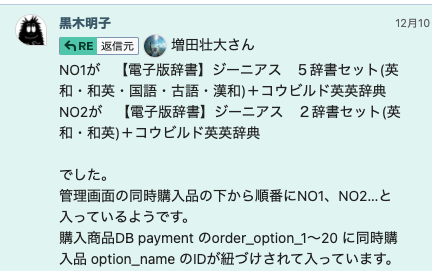

In [ ]:
_cms_data.calc_dict_buy_type()
_cms_data.data['副教材タイプ']

## MERGE - CMS and Juyugaoka Students

- 設計と違うが、自由が丘データがメインなので変更

In [ ]:
_merged_cms_jiyu = pd.merge(_jiyu_students.data, _cms_data.data, how='left', left_on=_jiyu_students.join_target_col(), right_on=_cms_data.join_target_col())


# extract cols
__target_cols = ['テスト番号', '合格学科', 'クラス２', '出席番号', '氏　名', 'id', '学籍番号', '生徒名', '教科書タイトル', '副教材タイプ']
_merged_cms_jiyu = _merged_cms_jiyu[__target_cols]

# '副教材タイプ' fill na -> BuyingDicType.NULL
_merged_cms_jiyu['副教材タイプ'].fillna(buying_dic_type.NULL, inplace=True)

display(_merged_cms_jiyu)

## CONCAT/MERGE - DONGURI ACC and CMS-JYG

- アカウント数と生徒数を比べると、「5辞書、2辞書いずれも購入しない生徒」もいるようだ

### Checking

- `[memo]` 名前マッチングからテスト番号-学籍番号マッチングに変更することで、失敗数が84件から18件に減った。

In [ ]:
# Split CMS-JYG into DIC_5/DIC_2/DIC_NONE
__merged_cms_jiyu_d5 = _merged_cms_jiyu[_merged_cms_jiyu['副教材タイプ'] == buying_dic_type.DIC_5].copy()
__merged_cms_jiyu_d2 = _merged_cms_jiyu[_merged_cms_jiyu['副教材タイプ'] == buying_dic_type.DIC_2].copy()
__merged_cms_jiyu_dN = _merged_cms_jiyu[_merged_cms_jiyu['副教材タイプ'] == buying_dic_type.DIC_NONE].copy()
__merged_cms_jiyu_NaN = _merged_cms_jiyu[_merged_cms_jiyu['副教材タイプ'] == buying_dic_type.NULL].copy()

_total_row = _merged_cms_jiyu.shape[0]

print(f'== 同時購入品として5辞書、2辞書いずれかを選んだ生徒')
print(f'5辞書 購入者数 = {__merged_cms_jiyu_d5.shape[0]} / {_total_row} (準備済みアカウント数: {_dongri_data_5dic.data.shape[0]})')
print(f'2辞書 購入者数 = {__merged_cms_jiyu_d2.shape[0]} / {_total_row} (準備済みアカウント数: {_dongri_data_2dic.data.shape[0]})')
print()

print(f'== 同時購入品として5辞書、2辞書いずれかも選んでない生徒')
print(f'非購入者数 = {__merged_cms_jiyu_dN.shape[0]} / {_total_row}')
print()

print(f'== 文字化けなどを理由にCMS側に対応するデータが見つけられなかった生徒（手動作業）')
print(f'手動オペレーション対象者数 = {__merged_cms_jiyu_NaN.shape[0]} / {_total_row}')
print()

### RESULTS1 - Attach account info to students rows

In [ ]:
# dic 5
_acc_rows_d5 = _dongri_data_5dic.get_head(__merged_cms_jiyu_d5.shape[0])
# -- concat cols は index が一致するものをつなぐので整えておく
__merged_cms_jiyu_d5.reset_index(drop=True, inplace=True)
_acc_rows_d5.reset_index(drop=True, inplace=True)
_cms_jyg_acc_d5 = pd.concat([__merged_cms_jiyu_d5, _acc_rows_d5], axis=1) # axis=columns,1


# dic 2
_acc_rows_d2 = _dongri_data_2dic.get_head(__merged_cms_jiyu_d2.shape[0])
# -- concat cols は index が一致するものをつなぐので整えておく
__merged_cms_jiyu_d2.reset_index(drop=True, inplace=True)
_acc_rows_d2.reset_index(drop=True, inplace=True)
_cms_jyg_acc_d2 = pd.concat([__merged_cms_jiyu_d2, _acc_rows_d2], axis=1) # axis=columns,1

# dic None
# -- 不要

# Concat vertically
cms_jyg_acc = pd.concat([_cms_jyg_acc_d5, _cms_jyg_acc_d2], axis=0) # axis=rows:0
cms_jyg_acc.fillna(value="アカウント不足", inplace=True)
cms_jyg_acc

### RESULTS2 - No Buying data

- 非購入者のデータ

In [ ]:
cms_jyg_no_buyer = __merged_cms_jiyu_dN.copy()
cms_jyg_no_buyer.reset_index(drop=True, inplace=True)
cms_jyg_no_buyer

### RESULTS3 - To Manual Operate Data

- CMSデータとマッチングできなかった jyg データ
- jyg データとマッチングしていない CMSデータ（新1年のみ）

In [ ]:
# CMSデータとマッチングできなかった jyg データ
jyg_manual_operate = __merged_cms_jiyu_NaN[['テスト番号', '合格学科', 'クラス２', '出席番号', '氏　名']].copy()
jyg_manual_operate.reset_index(drop=True, inplace=True)
jyg_manual_operate.head(3)

In [ ]:
# jyg データとマッチングしていない CMSデータ（新1年のみ、前処理で抽出済み）

# -- マッチング成功した '学籍番号' 一覧取得
_successfully_matched_ids = []
_successfully_matched_ids.extend(cms_jyg_acc['学籍番号'].values)
_successfully_matched_ids.extend(cms_jyg_no_buyer['学籍番号'].values)

# -- これを含まないCMSデータだけ取得
_cms_newbee_unmatched = _cms_data.data[~_cms_data.data['学籍番号'].isin(_successfully_matched_ids)].copy()
__target_cols = ['id', '学籍番号', '生徒名', '教科書タイトル', '副教材タイプ']
_cms_newbee_unmatched = _cms_newbee_unmatched[__target_cols]
_cms_newbee_unmatched.reset_index(drop=True, inplace=True)
_cms_newbee_unmatched.head(8)

## EXPORT

- 下記を分けて出力する
  - CMSに対応データが見つかったデータ（自動算出 **成功**）
  - 学籍番号入力ミスなどにより、CMSに対応データが見つからなかったデータ（自動算出 **失敗**）
    - ★手動オペレーションに利用
  - 残りのアカウント情報 - 5辞書
  - 残りのアカウント情報 - 2辞書

### Fmt

- Excel File: `学生情報・DONGURIアカウント情報紐付け結果一覧.xlsx`
  - Sheet: `購入者` - RESULTS1
  - Sheet: `非購入者` - RESULTS2
- Excel File: `DONGURIアカウント情報紐付けに失敗した学生一覧.xlsx`
  - Sheet: `生徒一覧` - RESULTS3
  - Sheet: `購入情報-マッチング候補` - RESULTS3
- Excel File: `DONGURI残りのアカウント一覧.xlsx` - RSULTS4

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_excel.html?highlight=to_excel#pandas.DataFrame.to_excel

In [ ]:
_fn_result = '学生情報・DONGURIアカウント情報紐付け結果一覧.xlsx'
_fp_result = Config.join_path([cfg.root, _fn_result])
with pd.ExcelWriter(_fp_result) as writer:
  cms_jyg_acc.to_excel(writer, sheet_name='購入者', index=False)
  cms_jyg_no_buyer.to_excel(writer, sheet_name='非購入者', index=False)

In [ ]:
_fn_failed_students = 'DONGURIアカウント情報紐付けに失敗した学生一覧.xlsx'
_fp_failed_students = Config.join_path([cfg.root, _fn_failed_students])
with pd.ExcelWriter(_fp_failed_students) as writer:
  jyg_manual_operate.to_excel(writer, sheet_name='生徒一覧', index=False)
  _cms_newbee_unmatched.to_excel(writer, sheet_name='購入情報-マッチング候補', index=False)

In [ ]:
_fn_rest_dongri_acc = 'DONGURI残りのアカウント一覧.xlsx'
_fp_rest_dongri_acc = Config.join_path([cfg.root, _fn_rest_dongri_acc])
with pd.ExcelWriter(_fp_rest_dongri_acc) as writer:
  _dongri_data_5dic.get_rest_of().to_excel(writer, sheet_name='5辞書アカウント', index=False)
  _dongri_data_2dic.get_rest_of().to_excel(writer, sheet_name='2辞書アカウント', index=False)